# Imports

In [1]:
import tensorflow as tf 
import tensorflow_datasets as tfds
import matplotlib.pyplot as plt
import keras_nlp

# Load the data

In [2]:
#IMDB review dataset
imdb = tfds.load('imdb_reviews', as_supervised=True, download=True)

Dl Completed...: 0 url [00:00, ? url/s]

Dl Size...: 0 MiB [00:00, ? MiB/s]

Generating splits...:   0%|          | 0/3 [00:00<?, ? splits/s]

Generating train examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6PBAH7_1.0.0/imdb_reviews-train.tfrecor…

Generating test examples...:   0%|          | 0/25000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6PBAH7_1.0.0/imdb_reviews-test.tfrecord…

Generating unsupervised examples...:   0%|          | 0/50000 [00:00<?, ? examples/s]

Shuffling /root/tensorflow_datasets/imdb_reviews/plain_text/incomplete.6PBAH7_1.0.0/imdb_reviews-unsupervised.…

Dataset imdb_reviews downloaded and prepared to /root/tensorflow_datasets/imdb_reviews/plain_text/1.0.0. Subsequent calls will reuse this data.


In [3]:
train_reviews = imdb['train'].map(lambda reviews, labels: reviews)
train_labels = imdb['train'].map(lambda reviews, labels: labels)

test_reviews = imdb['test'].map(lambda reviews, labels: reviews) 
test_labels = imdb['test'].map(lambda reviews, labels: labels)

# Prepare

In [4]:
# #compute the subword vocab and save to a file
# keras_nlp.tokenizers.compute_word_piece_vocabulary(
#     train_reviews,
#     vocabulary_size=8000,
#     reserved_tokens=["[PAD]", "[UNK]"],
#     vocabulary_output_file='imdb_vocab_subwords.txt'
# )

In [5]:
#initialize the subword tokenizer
subword_tokenizer = keras_nlp.tokenizers.WordPieceTokenizer(
    vocabulary='/kaggle/input/imdb-subword-vocabulary/imdb_vocab_subwords.txt'
)

In [6]:
SHUFFLE_BUFFER_SIZE = 10000
PREFETCH_BUFFER_SIZE = tf.data.AUTOTUNE
BATCH_SIZE = 256
PADDING_TYPE = 'pre'
TRUNC_TYPE = 'post'

In [7]:
def padding_func(sequences):
    sequences = sequences.ragged_batch(batch_size=sequences.cardinality())

    sequences = sequences.get_single_element()

    padded_sequences = tf.keras.utils.pad_sequences(sequences.numpy(),
                                                    truncating=TRUNC_TYPE,
                                                    padding=PADDING_TYPE)
    
    padded_sequences = tf.data.Dataset.from_tensor_slices(padded_sequences)

    return padded_sequences

In [8]:
# generate integer sequences using the subword tokenizer
train_sequences_subword = train_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)
test_sequences_subword = test_reviews.map(lambda review: subword_tokenizer.tokenize(review)).apply(padding_func)

# combine the integer sequences and labels
train_dataset_vectorized = tf.data.Dataset.zip(train_sequences_subword, train_labels)
test_dataset_vectorized = tf.data.Dataset.zip(test_sequences_subword, test_labels)

# Optimize teh datasets for training
train_dataset_final = (train_dataset_vectorized
                       .shuffle(SHUFFLE_BUFFER_SIZE)
                       .cache()
                       .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                       .batch(BATCH_SIZE)
                        )

test_dataset_final = (test_dataset_vectorized
                      .cache()
                      .prefetch(buffer_size=PREFETCH_BUFFER_SIZE)
                      .batch(BATCH_SIZE)
                      )


# Plot history

In [9]:
def plot_loss_acc(history):
  '''Plots the training and validation loss and accuracy from a history object'''
  acc = history.history['accuracy']
  val_acc = history.history['val_accuracy']
  loss = history.history['loss']
  val_loss = history.history['val_loss']

  epochs = range(len(acc))

  fig, ax = plt.subplots(1,2, figsize=(12, 6))
  ax[0].plot(epochs, acc, 'bo', label='Training accuracy')
  ax[0].plot(epochs, val_acc, 'b', label='Validation accuracy')
  ax[0].set_title('Training and validation accuracy')
  ax[0].set_xlabel('epochs')
  ax[0].set_ylabel('accuracy')
  ax[0].legend()

  ax[1].plot(epochs, loss, 'bo', label='Training Loss')
  ax[1].plot(epochs, val_loss, 'b', label='Validation Loss')
  ax[1].set_title('Training and validation loss')
  ax[1].set_xlabel('epochs')
  ax[1].set_ylabel('loss')
  ax[1].legend()

  plt.show()


# Single LSTM

## Build the model

In [10]:
#model params
EMBEDDING_DIM = 64
LSTM_DIM = 64
DENSE_DIM = 64

# build the model
model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding (Embedding)                │ (None, None, 64)            │         488,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional (Bidirectional)        │ (None, 128)                 │          66,048 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense (Dense)                        │ (None, 64)                  │           8,256 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_1 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 563,009 (2.15 MB)

 Trainable params: 563,009 (2.15 MB)

 Non-trainable params: 0 (0.00 B)

In [11]:
model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

In [12]:
NUM_EPOCHS = 5

history = model.fit(
    train_dataset_final,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset_final
)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 73s 693ms/step - accuracy: 0.6283 - loss: 0.6192 - val_accuracy: 0.8569 - val_loss: 0.3388
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 686ms/step - accuracy: 0.8696 - loss: 0.3150 - val_accuracy: 0.8571 - val_loss: 0.3354
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 686ms/step - accuracy: 0.8985 - loss: 0.2549 - val_accuracy: 0.8558 - val_loss: 0.3386
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 686ms/step - accuracy: 0.9041 - loss: 0.2446 - val_accuracy: 0.8654 - val_loss: 0.3355
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 67s 686ms/step - accuracy: 0.9153 - loss: 0.2231 - val_accuracy: 0.8592 - val_loss: 0.3942


## Visualize 

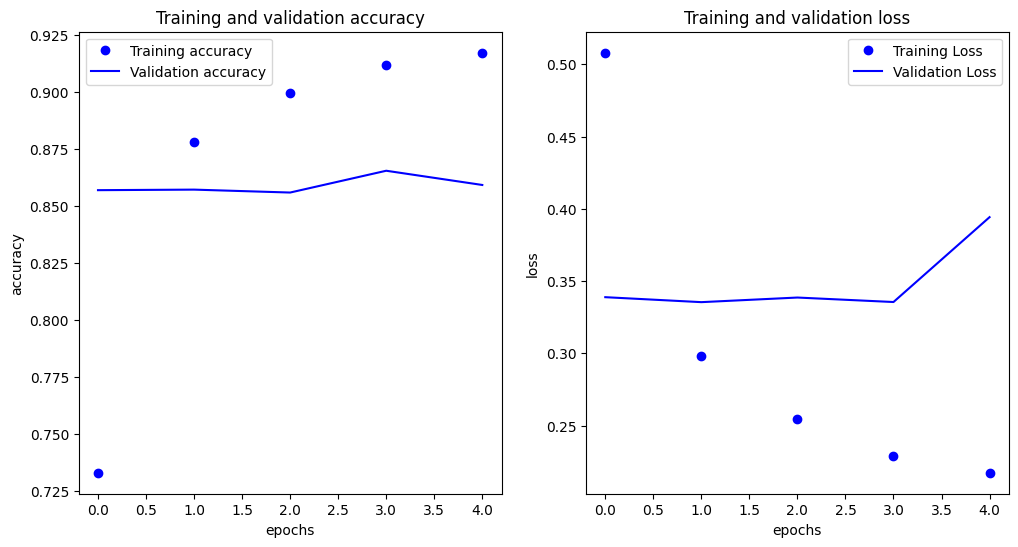

In [13]:
plot_loss_acc(history)

# Multiple LSTM

## Build the model

In [14]:
#model params
EMBEDDING_DIM = 64
LSTM1_DIM = 32
LSTM2_DIM = 16
DENSE_DIM = 64

# build the model
multi_model = tf.keras.Sequential([
    tf.keras.Input(shape=(None,)),
    tf.keras.layers.Embedding(subword_tokenizer.vocabulary_size(), EMBEDDING_DIM),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM1_DIM, return_sequences=True)),
    tf.keras.layers.Bidirectional(tf.keras.layers.LSTM(LSTM2_DIM)),
    tf.keras.layers.Dense(DENSE_DIM, activation='relu'),
    tf.keras.layers.Dense(1, activation='sigmoid')
])

multi_model.summary()

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_1 (Embedding)              │ (None, None, 64)            │         488,640 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_1 (Bidirectional)      │ (None, None, 64)            │          24,832 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_2 (Bidirectional)      │ (None, 32)                  │          10,368 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_2 (Dense)                      │ (None, 64)                  │           2,112 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_3 (Dense)                      │ (None, 1)                   │              65 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 526,017 (2.01 MB)

 Trainable params: 526,017 (2.01 MB)

 Non-trainable params: 0 (0.00 B)

In [15]:
multi_model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

## Train the model

In [16]:
NUM_EPOCHS = 5

multi_history = multi_model.fit(
    train_dataset_final,
    epochs=NUM_EPOCHS,
    validation_data=test_dataset_final
)

Epoch 1/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 107s 1s/step - accuracy: 0.6118 - loss: 0.6295 - val_accuracy: 0.8267 - val_loss: 0.4030
Epoch 2/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.8641 - loss: 0.3274 - val_accuracy: 0.8703 - val_loss: 0.3193
Epoch 3/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9134 - loss: 0.2285 - val_accuracy: 0.8640 - val_loss: 0.3609
Epoch 4/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9283 - loss: 0.1954 - val_accuracy: 0.8332 - val_loss: 0.4848
Epoch 5/5
98/98 ━━━━━━━━━━━━━━━━━━━━ 104s 1s/step - accuracy: 0.9125 - loss: 0.2156 - val_accuracy: 0.8359 - val_loss: 0.4111


## Visualize 

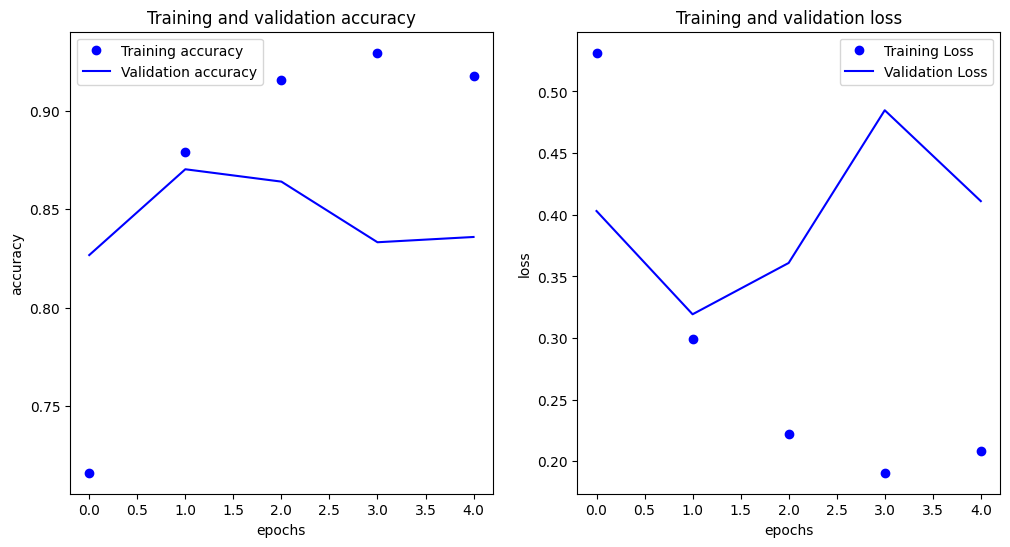

In [17]:
plot_loss_acc(multi_history)